# **Big Data and Cloud Computing - Assignment 2**

**Students**: Amanda Tavares - 202103516, Arina Sanches - 202100371, Lirielly Vitorugo - 202100370



### **Requirements**
File EVENTS.csv.gz contains records of several events of patients collected during their stay in the ICU (Intensive Care Unit). This file, compressed, occupies 4.2 Gigabytes and almost **35 Gigabytes unziped**. You need to perform a full data analysis and learning with this data, possibly using the machine learning pipeline we studied in class. You do not need to use Apache Beam, but you are required to use a suitable tool in order to efficiently process this data. Among the tasks you will perform are:

+ Statistical analysis and visualization of data for each patient (SUBJECT_ID). Note: one patient can have more than one hospital admission (HADM_ID).

+ Predict length of stay. For this task you will need to choose a window size to train your data (too many days will delay decisions about patients when the system is deployed, too few days will probably produce a very shortsighted predictor. Choose with care).


### **Our Approach**
As you have seen in the requirement above, the amount of data that we are dealing is really huge and to deal with big data we need to use appropiate tools. Our first attempt was as follow: we tried to use **Google Colab** to run our pipelines, but the time spent to run each step was pretty high, even using **PySpark**. 

To solve this issue, we create a **spark cluster** at **Google Clound Platform** with **one master** and **N worker** (we use 5 workers), because using this architecture, we can see the details in the image below, we can run our pipelines in parallel and also scalate the power of the workers if needed. 

Therefore, with the problem of dealing with big data solved, we were able to undestand, analyse and visualise the data to be able to transform it in a proper way.Then we fit regression models and then predict the **length of stay** (LOS) for each patient.

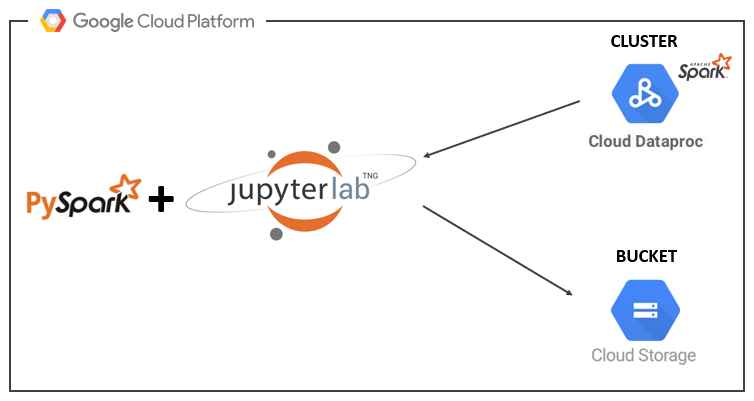

# Data Gathering

Importing the libraries

In [ ]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType
import pyspark.sql.functions as f
from pyspark.sql.functions import sum, avg, max, min, mean, count, to_date
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.functions import countDistinct
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
import matplotlib.ticker as tic # Imported Ticker
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sc.setLogLevel("WARN")

Reading the source tables (CHARTEVENTS, ICUSTAYS, DIAGNOSES_ICD, D_ICD_DIAGNOSES) from **GCP bucket** due the size

In [ ]:
%%time
# Readind file from GCP bucket using pyspark

# Create data frame for eventes
file_path = 'gs://lirielly/BDCC/CHARTEVENTS.csv'
dfe = spark.read.csv(file_path, header=True)
print(dfe.schema)
dfe.show()

# Create data frame for aditional information
file_path2 = 'gs://lirielly/BDCC/ICUSTAYS.csv'
dfai = spark.read.csv(file_path2, header=True)
print(dfai.schema)
dfai.show()

# Create data frame for aditional information
file_path3 = 'gs://lirielly/BDCC/DIAGNOSES_ICD.csv'
dfd = spark.read.csv(file_path3, header=True)
print(dfd.schema)
dfd.show()

# Create data frame for aditional information
file_path4 = 'gs://lirielly/BDCC/D_ICD_DIAGNOSES.csv'
dfd2 = spark.read.csv(file_path4, header=True)
print(dfd2.schema)
dfd2.show()

StructType(List(StructField(ROW_ID,StringType,true),StructField(SUBJECT_ID,StringType,true),StructField(HADM_ID,StringType,true),StructField(ICUSTAY_ID,StringType,true),StructField(ITEMID,StringType,true),StructField(CHARTTIME,StringType,true),StructField(STORETIME,StringType,true),StructField(CGID,StringType,true),StructField(VALUE,StringType,true),StructField(VALUENUM,StringType,true),StructField(VALUEUOM,StringType,true),StructField(WARNING,StringType,true),StructField(ERROR,StringType,true),StructField(RESULTSTATUS,StringType,true),StructField(STOPPED,StringType,true)))
+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+-------+-----+------------+-------+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME| CGID|VALUE|VALUENUM|VALUEUOM|WARNING|ERROR|RESULTSTATUS|STOPPED|
+------+----------+-------+----------+------+-------------------+-------------------+-----+-----+--------+--------+--

# Data Transformation

We decided to analyse one of the patient's hospitalization in details. To do that we filtered it on the database.

In [ ]:
# filter all the records from one patient
client_df = dfe.filter((f.col('SUBJECT_ID') == 36) & (f.col('HADM_ID') == 165660))

In [ ]:
# print shape for data frames
# print((dff.count(), len(dff.columns)))
# print((dfai.count(), len(dfai.columns)))

In [ ]:
%%time
# convert the VALUENUM column to double 
dff = dfe.withColumn("VALUENUM", dfe.VALUENUM.cast('double'))

CPU times: user 2.96 ms, sys: 364 µs, total: 3.32 ms
Wall time: 228 ms


In [ ]:
%%time
# printing the schema to look into the data types
dff.printSchema()

root
 |-- ROW_ID: string (nullable = true)
 |-- SUBJECT_ID: string (nullable = true)
 |-- HADM_ID: string (nullable = true)
 |-- ICUSTAY_ID: string (nullable = true)
 |-- ITEMID: string (nullable = true)
 |-- CHARTTIME: string (nullable = true)
 |-- STORETIME: string (nullable = true)
 |-- CGID: string (nullable = true)
 |-- VALUE: string (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: string (nullable = true)
 |-- ERROR: string (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)

CPU times: user 1.75 ms, sys: 0 ns, total: 1.75 ms
Wall time: 2.39 ms


To deal with huge volume of data we need to find a way to **aggregate** the data. In order to do so, we group the data by **"SUBJECT_ID"**, **"HADM_ID"** and **"ITEMID"** and take the mean of each variable **VALUENUM** for each ITEMID. ITEMID indicates the type of the exam that the patient did. And VALUENUM is the actual value of the exam.

In [ ]:
%%time
# Map-reduce grouping the same ITEMID by the mean
dffa = dff.groupBy("SUBJECT_ID", "HADM_ID", "ITEMID") \
    .agg(avg("VALUENUM").alias("avg_VALUENUM"))

CPU times: user 2.72 ms, sys: 4.3 ms, total: 7.02 ms
Wall time: 118 ms


In [ ]:
# Find Count of Null, None, NaN of All DataFrame Columns
# dffa.select([count(when(isnan('avg_VALUENUM') | col('avg_VALUENUM').isNull(), 'avg_VALUENUM')).alias('avg_VALUENUM') ]).show()

Continuing the data transformation. We need to tranform the aggregated "ITEMID" values in features. To do that we use the pivot function.

In [ ]:
%%time
pivot_df = dffa.groupBy("SUBJECT_ID", "HADM_ID")\
            .pivot("ITEMID")\
            .max("avg_VALUENUM")\
            .fillna(0)

CPU times: user 167 ms, sys: 59.1 ms, total: 226 ms
Wall time: 1min 46s


We thought that the total number of exams that the patient did during one hospitalization would help the model predict the LOS. Therefore, we create this feature to use in the model.

In [ ]:
%%time 
b = dff.groupBy("SUBJECT_ID", "HADM_ID").agg(countDistinct("ITEMID"))

CPU times: user 4.86 ms, sys: 631 µs, total: 5.49 ms
Wall time: 30.1 ms


In the next four steps we joined the principal table with the records of the EVENTS, but with the transformations that we did until here, with the additional tables ICUSTAYS, DIAGNOSES_ICD, D_ICD_DIAGNOSES to be able to get LOS and DIAGNOSES information.

In [ ]:
%%time 
joinedDF1 = pivot_df.join(dfai, ["SUBJECT_ID", "HADM_ID"], 'left')

CPU times: user 0 ns, sys: 3.94 ms, total: 3.94 ms
Wall time: 855 ms


In [ ]:
%%time 
joinedDF = joinedDF1.join(b, ["SUBJECT_ID", "HADM_ID"], 'left')

CPU times: user 3.76 ms, sys: 474 µs, total: 4.23 ms
Wall time: 672 ms


In [ ]:
%%time 
joinedDF2 = joinedDF.join(dfd, ["SUBJECT_ID", "HADM_ID"], 'left')

CPU times: user 12 µs, sys: 3.53 ms, total: 3.55 ms
Wall time: 827 ms


In [ ]:
%%time 
joinedDF_ICD9 = joinedDF2.join(dfd2, ["ICD9_CODE"], 'left')

CPU times: user 3.24 ms, sys: 414 µs, total: 3.65 ms
Wall time: 742 ms


By curiosity, we want to check the total number of unique patients in the database.

In [ ]:
# number of unique patients
joinedDF_ICD9.select(countDistinct("SUBJECT_ID")).show()

+--------------------------+
|count(DISTINCT SUBJECT_ID)|
+--------------------------+
|                     46467|
+--------------------------+



# Exploratory Data Analysis

To better **undestand** the data we want to perform a **exploratory data analysis**. **PySpark** does not provide good support to do **data visualizations**. We are more familiar with **matplotlib**, **seaborn** and **pandas libraries** to do this kind of **visualization analysis**. And in order to do that we need to take a sample of the data or use some kind of aggregation to reduce the size of data, because if we did not do that our environment would not be able to process that amount of data. 

In [ ]:
# take a sample of the data
sample = dfe.sample(0.001, seed=None)

In [ ]:
# converting the variables to a proper data type
sample = sample.withColumn("VALUE", sample.VALUE.cast('double'))
sample = sample.withColumn("VALUENUM", sample.VALUENUM.cast('double'))
sample = sample.withColumn("VALUEUOM", sample.VALUEUOM.cast('double'))

In [ ]:
# converting the spark dataframe to panda one
sample_df = sample.toPandas()

In [ ]:
# looking into the size of the sample
len(sample_df)

329866

In [ ]:
# looking the variables statistics
sample_df[["VALUE","VALUENUM","VALUEUOM"]].describe(include='all')

,VALUE,VALUENUM,VALUEUOM
count,134506.000000,145850.000000,0.0
mean,76.576805,71.018858,NaN
std,182.535641,176.141653,NaN
min,-300.000000,-300.000000,NaN
25%,10.400000,7.000000,NaN
50%,50.000000,40.000000,NaN
75%,97.900002,96.000000,NaN
max,14450.000000,14450.000000,NaN


We decided to analyse the continuous variables distributions. And we notice that VALUE and VALUENUM have the same distribution, the values are concentrated around zero, but we also see the presence of discrepant values.

array([[<AxesSubplot:title={'center':'VALUE'}>,
        <AxesSubplot:title={'center':'VALUENUM'}>,
        <AxesSubplot:title={'center':'VALUEUOM'}>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

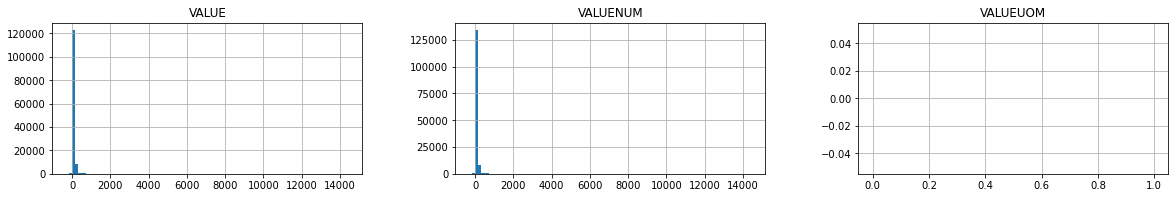

In [ ]:
# distribution plot
sample_df[["VALUE","VALUENUM","VALUEUOM"]].hist(bins=100, figsize=(20, 10), layout=(3, 3))

We did a **correlation analysis** for "VALUE","VALUENUM" and "VALUEUOM" variables and we saw that "VALUE" and "VALUENUM" are **perfectly correlated**, trus they have the same values so this behaviour was expected.



In [ ]:
# correlation analysis
corr = sample_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/conda/miniconda3/lib/python3.8/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,VALUE,VALUENUM,VALUEUOM
VALUE,1.000000,1.000000,nan
VALUENUM,1.000000,1.000000,nan
VALUEUOM,nan,nan,nan


Then we perform the categorical variables exploratory analysis. In all the charts we see the prevalence of just one of the classes. 

<AxesSubplot:xlabel='STOPPED', ylabel='count'>

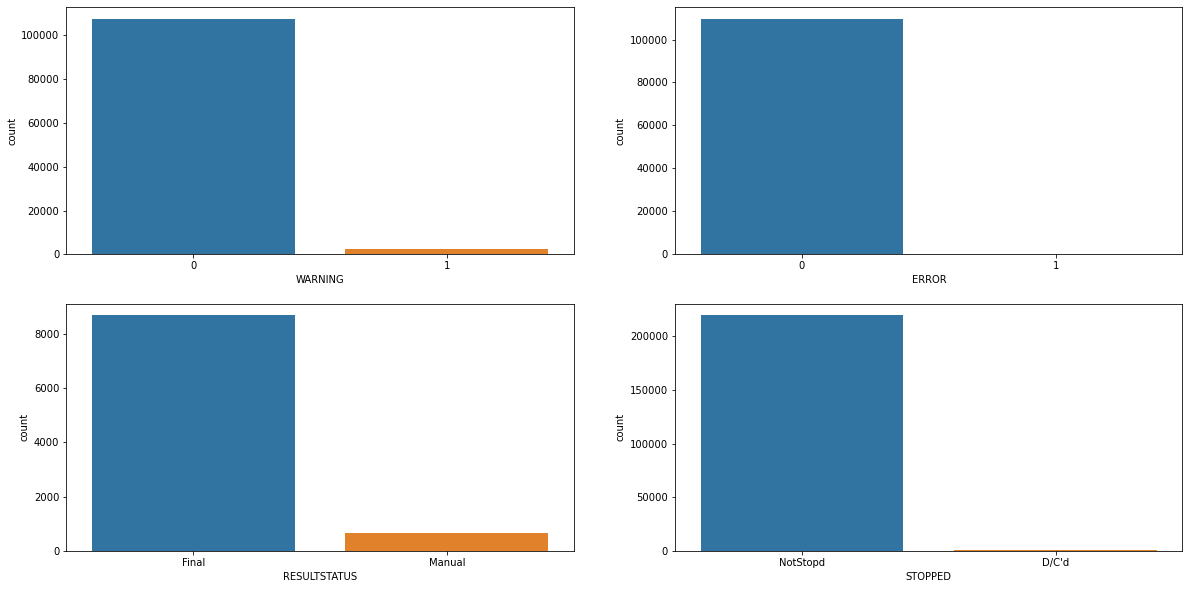

In [ ]:
# categorical variables visualization analysis 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

sns.countplot(data=sample_df, x='WARNING',ax=axes[0,0])
sns.countplot(data=sample_df, x='ERROR', ax=axes[0,1])
sns.countplot(data=sample_df, x='RESULTSTATUS',ax=axes[1,0])
sns.countplot(data=sample_df, x='STOPPED',ax=axes[1,1])

In order to do an exploratory data analysis to one patient we decided to look into the exams results that he did in one of his hospitalization.

In [ ]:
# converting variables to a proper data type
client_df = client_df.withColumn("VALUENUM", client_df.VALUENUM.cast('double'))
client_df = client_df.withColumn("ITEMID", client_df.ITEMID.cast('int'))
client_df.withColumn("CHARTTIME", to_date(col("CHARTTIME"),"yyyy-MM-dd HH:mm:ss"))

DataFrame[ROW_ID: string, SUBJECT_ID: string, HADM_ID: string, ICUSTAY_ID: string, ITEMID: int, CHARTTIME: date, STORETIME: string, CGID: string, VALUE: string, VALUENUM: double, VALUEUOM: string, WARNING: string, ERROR: string, RESULTSTATUS: string, STOPPED: string]

In [ ]:
# converting the spark datafreme to pandas dataframe
cdf = client_df.toPandas()

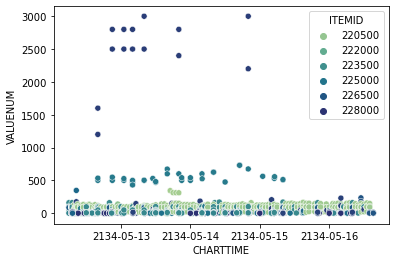

In [ ]:
# plotting the exams results from one patient in one of his hospiralization
axes2 = sns.scatterplot(data=cdf, x="CHARTTIME", y="VALUENUM", hue="ITEMID", palette= "crest")
axes2.xaxis.set_major_locator(tic.MaxNLocator(nbins=6))

We decided to take a look into the visualization of the LOS variable, as it is our target variable.

In [ ]:
# converting variables to a proper data type
joinedDF_ICD9 = joinedDF_ICD9.withColumn("LOS", joinedDF_ICD9.LOS.cast('double'))

In [ ]:
# converting the spark datafreme to pandas dataframe
jdf = joinedDF_ICD9.select('INTIME', 'SUBJECT_ID', 'HADM_ID', 'LOS', 'SHORT_TITLE').toPandas()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [ ]:
# converting variables to a proper data type
jdf["INTIME"] = pd.to_datetime(jdf["INTIME"])

In [ ]:
# statistical analysis for the LOS variable
jdf["LOS"].describe(include='all')

count    60921.000000
mean         4.932804
std          9.672145
min          0.000100
25%          1.108300
50%          2.093500
75%          4.502800
max        173.072500
Name: LOS, dtype: float64

Analysing the distribution graph and the boxplot graph we see that the LOS values are **concentrated between 0 and 25**, but we can see some **extreme** values, for example a **173 days of lenght of stay**, it is not frequent, but it is possible to happen.



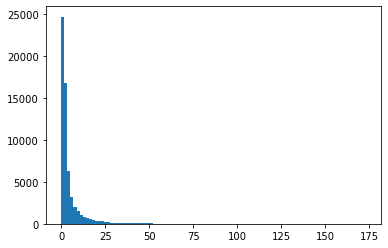

In [ ]:
# distribution plot
ax = jdf["LOS"].hist(bins=100)
ax.grid(False)

<AxesSubplot:xlabel='LOS'>

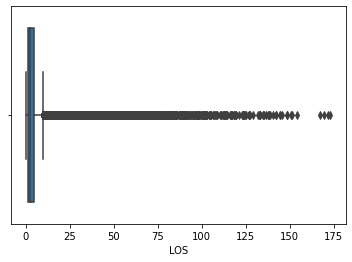

In [ ]:
# boxplot 
sns.boxplot(x='LOS', data=jdf)

Another relevant study, was to discover the most frequent diagnostic. Because of the large amout of diagnosis, only 20 most frequent ones were selected to be displayed.

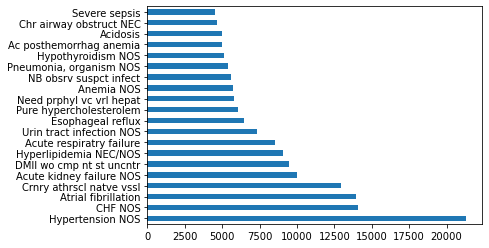

In [ ]:
jdf['SHORT_TITLE'].value_counts()[:20].plot(kind="barh")
plt.show()

Continuing our visualization analysis, we analyse the hospitalization time distribution for the 4 most frequent diagnosis. The distribution for those most frequent diagnosis was practically the same and the lenght of stay is between 0 and 7.5 days. 

[0.0,
 20.0,
 0.0,
 2500.0,
 0.0,
 20.0,
 0.0,
 2500.0,
 0.0,
 20.0,
 0.0,
 2500.0,
 0.0,
 20.0,
 0.0,
 2500.0]

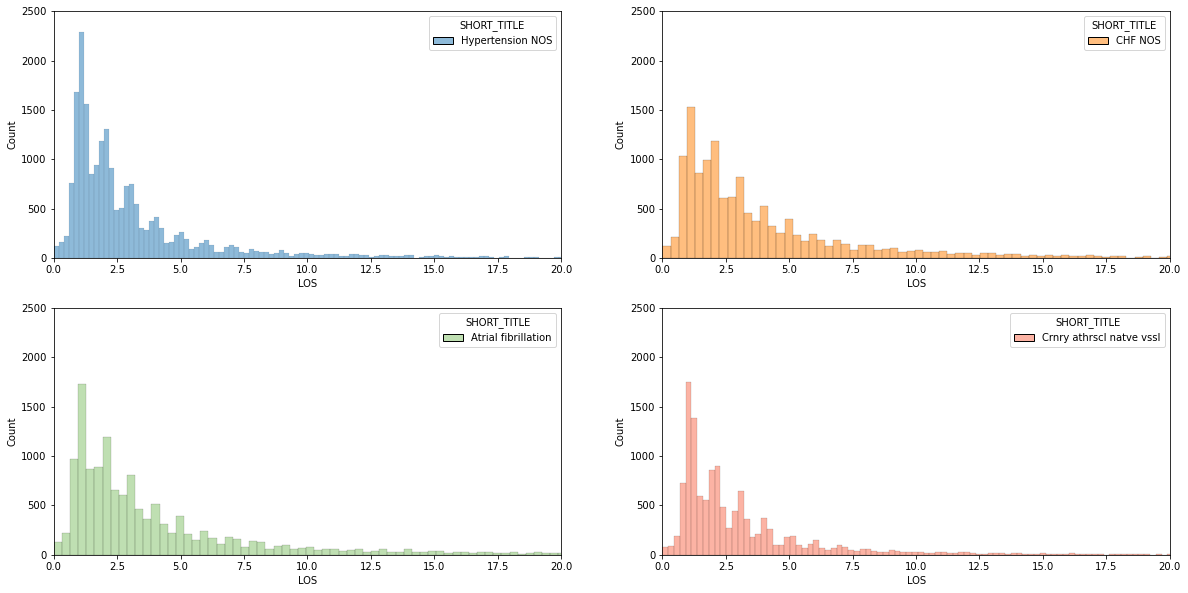

In [ ]:
# plotting the variables distribution
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
sns.histplot(data=jdf[jdf['SHORT_TITLE'].isin(['Hypertension NOS'])] , x="LOS", hue="SHORT_TITLE", ax=axes[0,0])
sns.histplot(data=jdf[jdf['SHORT_TITLE'].isin(['CHF NOS'])] , x="LOS", hue="SHORT_TITLE", ax=axes[0,1], palette= "Set1_r")
sns.histplot(data=jdf[jdf['SHORT_TITLE'].isin(['Atrial fibrillation'])] , x="LOS", hue="SHORT_TITLE", ax=axes[1,0], palette= "summer")
sns.histplot(data=jdf[jdf['SHORT_TITLE'].isin(['Crnry athrscl natve vssl'])] , x="LOS", hue="SHORT_TITLE", ax=axes[1,1], palette= "Reds")
# Defining custom 'xlim' 
custom_xlim = (0, 20)
custom_ylim = (0, 2500)
# Setting the values for all axes.
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

# Data Modeling

Finally, we adjust a regression model using 3 different regression approaches (**Linear Regression, Decision Tree and Gradient Boosting**). 
We **partitionate** the data in the follow way: **80% for thaining** and **20% for testing**.
To evaluate those models we use the **RMSE** (Root Mean Squared Error) error metric and the **R²**.

In [ ]:
%%time
# keep just the features that we will be used in the model and deleting the others
column_names = joinedDF.drop(*['ROW_ID', 'ICUSTAY_ID', 'DBSOURCE', 'INTIME', 'OUTTIME', 'SUBJECT_ID', 'HADM_ID', 'LOS', 
                               'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID', 'OW_ID', 'SEQ_NUM', 'ROW_ID', 
                               'SHORT_TITLE', 'LONG_TITLE']).schema.names

CPU times: user 27.5 ms, sys: 434 µs, total: 28 ms
Wall time: 572 ms


In [ ]:
%%time
# put the data into a proprer format to give it to the model:  a vector of features and a column for the target variable
vectorAssembler = VectorAssembler(inputCols = column_names, outputCol = 'features')
dfv = vectorAssembler.transform(joinedDF)
dfv = dfv.select(['features', 'LOS'])
dfv.show(3)

22/06/29 14:33:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1355.2 KiB
22/06/29 14:34:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+--------------------+-------+
|            features|    LOS|
+--------------------+-------+
|(6464,[98,642,750...| 1.8504|
|(6464,[97,98,99,1...|14.5306|
|(6464,[98,106,164...| 1.0695|
+--------------------+-------+
only showing top 3 rows

CPU times: user 816 ms, sys: 176 ms, total: 992 ms
Wall time: 9min 21s


In [ ]:
# converting LOS to a proper data type
dfv = dfv.withColumn("LOS", dfv.LOS.cast('double'))

In [ ]:
# count null in LOS feature
dfv.select([count(when(isnan('LOS') | col('LOS').isNull(), 'LOS')).alias('LOS') ]).show()

# look into final dataframe shape
# print((dfv.count(), len(dfv.columns)))

+---+
|LOS|
+---+
| 66|
+---+



We decide to **drop** the null values of **LOS** as our data has more than **60k observations** and the number of null in the LOS variable was only **66 records**.

In [ ]:
%%time
# dropping the nulls in LOS variable
dfv = dfv.na.drop()

In [ ]:
%%time
# Training linear regression model

# spliting the data in training and testing data
splits = dfv.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

lr = LinearRegression(featuresCol='features', labelCol='LOS', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the linear regression model
lrModel = lr.fit(train_df)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
train_df.describe().show()

22/06/29 15:16:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1354.9 KiB
22/06/29 15:27:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1354.9 KiB
22/06/29 15:28:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/06/29 15:30:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/06/29 15:30:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/06/29 15:32:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/06/29 15:32:13 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/06/29 15:32:13 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/06/29 15:32:13 WARN org.apache.spark.scheduler.DAGSc

Coefficients: (6464,[2,4,99,103,135,250,261,381,482,675,703,724,733,764,871,882,924,946,947,951,960,1013,1179,1182,1184,1185,1186,1192,1194,1201,1240,1241,1252,1253,1278,1330,1335,1336,1337,1338,1362,1402,1516,1625,1635,1651,1652,1653,1654,1698,1699,1700,1710,1713,1715,1716,1719,1722,1783,1810,1820,1826,1867,1900,1902,1964,1981,1995,1996,2004,2012,2013,2046,2047,2048,2055,2063,2075,2076,2108,2179,2183,2184,2222,2223,2226,2228,2229,2251,2252,2253,2258,2313,2314,2315,2488,2707,2758,2924,3137,3205,3212,3227,3228,3248,3271,3280,3300,3312,3320,3325,3327,3345,3347,3349,3367,3377,3378,3380,3384,3402,3418,3428,3429,3435,3463,3477,3519,3520,3521,3532,3545,3553,3554,3555,3556,3557,3558,3564,3571,3580,3590,3591,3594,3598,3600,3612,3613,3616,3617,3620,3627,3631,3632,3633,3635,3636,3639,3678,3693,3696,3699,3702,3703,3822,3826,3935,4008,4016,4044,4119,4124,4193,4200,4211,4234,4237,4517,4611,4634,4697,4718,4726,4789,4842,4853,4864,4906,4959,5091,5190,5248,5285,5362,5393,5396,5398,5422,5445,5472,5546,

22/06/29 15:53:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1355.2 KiB
22/06/29 15:54:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB


+--------------------+
|           residuals|
+--------------------+
| -10.952224262662574|
|  -7.284824262662573|
| -1.2475242626625729|
|   76.14947573733743|
|  36.713022756909616|
|  3.2496847231362853|
| -0.7701650892150003|
| -3.4035839639240306|
|   -2.02808096080033|
|  1.6644190391996698|
|0.053059389512130295|
| 0.05648994217151926|
|  0.9831276447608559|
|  -5.919004407426902|
|   6.306593018861506|
| -1.9900596335591025|
|   9.451437232355694|
| -0.4546387951631701|
|   9.841783113736158|
| -12.546899062877579|
+--------------------+
only showing top 20 rows

RMSE: 4.779929
r2: 0.759029


22/06/29 16:04:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1354.9 KiB
22/06/29 16:04:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.9 MiB


+-------+-----------------+
|summary|              LOS|
+-------+-----------------+
|  count|            48768|
|   mean|4.942816113024935|
| stddev|9.737403639526109|
|    min|           1.0E-4|
|    max|         173.0725|
+-------+-----------------+

CPU times: user 2.33 s, sys: 559 ms, total: 2.89 s
Wall time: 58min 53s


In [ ]:
%%time
# Testing linear regression model
lr_predictions = lrModel.transform(test_df)
lr_predictions.select("prediction","LOS","features").show(5)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="LOS", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

test_result = lrModel.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

22/06/29 16:15:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1355.2 KiB
22/06/29 16:16:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB


+------------------+------+--------------------+
|        prediction|   LOS|            features|
+------------------+------+--------------------+
|23.027977243090383|8.1266|(6464,[6,97,98,99...|
|  8.12458096080033|0.6543|(6464,[67,97,98,9...|
| 4.270059602860157|1.6286|(6464,[92,98,106,...|
|18.391719646585894|28.057|(6464,[97,98,99,1...|
| 16.19662171078871|2.0158|(6464,[97,98,99,1...|
+------------------+------+--------------------+
only showing top 5 rows



22/06/29 16:25:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1354.9 KiB
22/06/29 16:26:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/06/29 16:28:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB


R Squared (R2) on test data = 0.728163


22/06/29 16:37:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1354.9 KiB
22/06/29 16:37:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/06/29 16:39:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB


Root Mean Squared Error (RMSE) on test data = 4.9039
CPU times: user 1.33 s, sys: 360 ms, total: 1.69 s
Wall time: 33min 3s


In [ ]:
predictions = lrModel.transform(test_df)
predictions.select("prediction","LOS","features").show()

22/06/29 16:48:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1355.2 KiB
22/06/29 16:49:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB


+------------------+-------+--------------------+
|        prediction|    LOS|            features|
+------------------+-------+--------------------+
|23.027977243090383| 8.1266|(6464,[6,97,98,99...|
|  8.12458096080033| 0.6543|(6464,[67,97,98,9...|
| 4.270059602860157| 1.6286|(6464,[92,98,106,...|
|18.391719646585894| 28.057|(6464,[97,98,99,1...|
| 16.19662171078871| 2.0158|(6464,[97,98,99,1...|
| 16.19662171078871|39.8814|(6464,[97,98,99,1...|
|15.775053024924402|25.0955|(6464,[97,98,99,1...|
|14.473591710271704| 8.3375|(6464,[97,98,99,1...|
|14.473591710271704|27.9899|(6464,[97,98,99,1...|
|  8.62757450827937| 1.2109|(6464,[97,98,99,1...|
|11.375120829163297| 1.5941|(6464,[97,98,99,1...|
| 4.002558918053368| 2.0231|(6464,[97,98,99,1...|
| 5.015751978842007| 2.0573|(6464,[97,98,99,1...|
|11.470547276913681|25.2519|(6464,[97,98,99,1...|
|4.0187050894739755| 1.3126|(6464,[97,98,99,1...|
| 4.192867754633848| 2.3309|(6464,[97,98,99,1...|
| 4.354412419205673| 3.2255|(6464,[97,98,99,1...|


In [ ]:
%%time
# Training decision tree regression model

from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'LOS')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

dt_evaluator = RegressionEvaluator(
    labelCol="LOS", predictionCol="prediction", metricName="r2")
r2 = dt_evaluator.evaluate(dt_predictions)

dt_evaluator = RegressionEvaluator(
    labelCol="LOS", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R Squared (R2) on test data = %g" % r2)

22/06/29 16:59:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1354.9 KiB
22/06/29 17:00:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/06/29 17:01:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/06/29 17:03:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/06/29 17:04:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/29 17:05:59 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/29 17:06:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/29 17:06:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/29 17:06:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binar

Root Mean Squared Error (RMSE) on test data = 5.17842
R Squared (R2) on test data = 0.696876
CPU times: user 1.4 s, sys: 384 ms, total: 1.79 s
Wall time: 38min 49s


In [ ]:
%%time
# Training Gradient-boosted tree regression model

from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'LOS', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

gbt_evaluator = RegressionEvaluator(
    labelCol="LOS", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions)

gbt_evaluator = RegressionEvaluator(
    labelCol="LOS", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("R Squared (R2) on test data = %g" % r2)

22/06/29 17:38:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1354.9 KiB
22/06/29 17:48:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1354.9 KiB
22/06/29 17:49:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/06/29 17:49:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/06/29 17:51:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/06/29 17:53:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/29 17:54:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/06/29 17:54:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/06/29 17:54:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task bi

Root Mean Squared Error (RMSE) on test data = 4.53435
R Squared (R2) on test data = 0.76759
CPU times: user 1.9 s, sys: 559 ms, total: 2.46 s
Wall time: 48min 47s


## **Results Summarization**

|Model|RMSE|R²|
|-----|----|--|
|Gradient Boosting|4.53|0.77|
|Linear Regression|4.90|0.73|
|Decision Tree|5.18|0.70|

We can see **Gradient Boosting** was the model that had the best performance in our data. Due to **RMSE of 4.53** and **R² of 0.77**.

## **Model Execution Time Summarization**
|Model|Execution time|
|-----|----|
|Decision Tree|38min 49s|
|Gradient Boosting|48min 47s|
|Linear Regression|58min 53s|

#Conclusions

During the execution of this project we were able to face some of the common problems that happen when we deal with big data. 

+ We had **huge amount of data** and it took a **lot time to store, process, visualise**.
+ Our first and failed approach was to use **Google Colab** to run our pipeline, but it **took pretty long time** to execute the steps. And then we realize that we could use **Spark Clusters** attached to **Jupter Notebook** at the **Google Cloud Platform** to really use the **full power of parallelization**.

All of the tested model reached **similar results**, with **Gradient Boosting** getting **slightly better results**, so if we need to choose one model to use in the production environment we shoud use this model.

The experience that we had dealing with **big data** was very **insightful** and we were able to **learn** how to use **different tool and techniques** to complete the proposed task.